# Topic modelling

* [1. Imports and loading data](#chapter1)
* [2. Exploring data, cleaning and preprocessing](#chapter2)
    * [2.1 Converting d_types](#section_2_1)
    * [2.2 Exploring length of line text](#section_2_2)
    * [2.3 Removing stopwords](#section_2_3)
    * [2.4 Removing most common words](#section_2_4)
    * [2.5 Removing names](#section_2_5)
    * [2.6 Removing very short words](#section_2_6)
    * [2.7 Lemmatizing words](#section_2_7)
    * [2.8 Removing punctuation](#section_2_8)
    * [2.9 Removing meaningless words manually](#section_2_9)
* [3. Grouping data for superior topic modelling](#chapter3)
    * [3.1 Grouping by scene](#section_3_1)
    * [3.2 Grouping by episode](#section_3_2)
* [4. Topic modelling](#chapter4)
    * [4.1 NMF: Finding optimal no of topics](#section_4_1)
    * [4.2 LDA: Finding optimal no of topics](#section_4_2)
    * [4.3 Displaying NMF topics](#section_4_2)
    * [4.4 Displaying LDA topics](#section_4_4)
* [5. Zero-shot classification](#chapter4)

    

## 1. Imports and loading data <a class="anchor" id="chapter1"></a>

In [413]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from collections import Counter
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, HashingVectorizer, CountVectorizer
from transformers import pipeline
from nltk.stem import WordNetLemmatizer
import re
import string
from gensim.models import CoherenceModel
import gensim.corpora as corpora
import matplotlib.ticker as mticker
TOKENIZERS_PARALLELISM=True
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings('ignore')
from sklearn.utils import all_estimators
from sklearn.exceptions import ConvergenceWarning

In [ ]:
pip i

In [242]:
df = pd.read_csv("The_Office_lines.csv")
df.head()

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False


## 2. Exploring data, cleaning and preprocessing <a class="anchor" id="chapter2"></a>

### 2.1 Converting dtypes <a class="anchor" id="section_2_1"></a>

In [243]:
df.dtypes

id            int64
season        int64
episode       int64
scene         int64
line_text    object
speaker      object
deleted        bool
dtype: object

In [244]:
df = df.convert_dtypes()

In [245]:
df.dtypes

id             Int64
season         Int64
episode        Int64
scene          Int64
line_text     string
speaker       string
deleted      boolean
dtype: object

### 2.2 Exploring length of line_text <a class="anchor" id="section_2_2"></a>

In [246]:
df['line_length']  = df.line_text.str.len()

In [247]:
df.line_length.describe()

count    59909.000000
mean        59.692467
std         70.528507
min          1.000000
25%         17.000000
50%         37.000000
75%         75.000000
max       1439.000000
Name: line_length, dtype: float64

The average amount of characters in each line of dialogue is around 60, with some lines having just one character. It might be useful to remove some of these short lines at some point

In [248]:
df['line_text_pp'] = df['line_text'].apply(lambda x:x.lower())

### 2.3 Removing stopwords <a class="anchor" id="section_2_3"></a>

In [249]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [250]:
def remove_stopwords(dialogues):
    remove_stopwords_ufunc = np.frompyfunc(lambda x: ' '.join([w for w in x.split() if w.lower() not in stop_words]), 1, 1)
    dialogues = remove_stopwords_ufunc(dialogues)
    return dialogues

In [251]:
df['line_text_pp'] = remove_stopwords(df.line_text_pp)

### 2.4 Removing common words <a class="anchor" id="section_2_4"></a>

After doing some topic modelling, I felt like the clusters of words didn't mean so much. This kind of makes sense, as the large majority of the dialogue is quite generic. Therefore, I want to try removing the most common words from the text, in order to access more niche topics.

In [ ]:
common_words_list = [word for word, count in Counter(" ".join(df.line_text_pp).split()).most_common(100)]

In [254]:
def remove_commonwords(dialogues):
    remove_common_words_ufunc = np.frompyfunc(lambda x: ' '.join([w for w in x.split() if w.lower() not in common_words_list]), 1, 1)
    dialogues = remove_common_words_ufunc(dialogues)
    return dialogues

In [255]:
df['line_text_pp'] = remove_commonwords(df.line_text_pp)

In [256]:
df.head()

,id,season,episode,scene,line_text,speaker,deleted,line_length,line_text_pp
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False,78,jim. quarterlies things library?
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,42,told close so...
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False,83,"master guidance? saying, grasshopper?"
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,42,"actually, called here,"
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,47,show done.


In [257]:
df['new_line_length']  = df.line_text_pp.str.len()
df.new_line_length.describe()

count    59909.000000
mean        32.683203
std         40.661115
min          0.000000
25%          8.000000
50%         20.000000
75%         42.000000
max        693.000000
Name: new_line_length, dtype: float64

Based on some preliminary topic modelling attempts, I want to try removing character names and words with 3 or less characters.

### 2.5 Removing names <a class="anchor" id="section_2_5"></a>

In [277]:
def remove_names(df, col):
    character_names = ['phyllis', 'darryl', 'michael', 'pam', 'kevin', 'angela', 'dwight', 'creed', 'jim', 'ryan', 'erin', 'andy', 'oscar', 'stanley', 'scott', 'jan', 'schrute', 'david', 'kelly', 'meredith', 'nellie', 'wallas', 'robert', 'deangelo', 'holly']
    # Create a regular expression pattern that matches any of the names in the character_names list
    pattern = '|'.join(r"\b{}\b".format(name) for name in character_names)
    # Replace the matched words in the specified column with an empty string
    df[col] = df[col].str.replace(pattern, '', regex=True)
    return df

In [259]:
df = remove_names(df, 'line_text_pp')

### 2.6 Removing very shortwords <a class="anchor" id="section_2_6"></a>

In [260]:
def remove_short_words(df, col):
    # Create a regular expression pattern that matches any word of four characters or fewer
    pattern = r"\b\w{1,4}\b"
    # Replace the matched words in the specified column with an empty string
    df[col] = df[col].str.replace(pattern, '', regex=True)
    return df

In [351]:
df = remove_short_words(df, 'line_text_pp')

In [262]:
df.head()

,id,season,episode,scene,line_text,speaker,deleted,line_length,line_text_pp,new_line_length
0,1,1,1,1,All right Jim. Your quarterlies look very good. How are things at the library?,Michael,False,78,. quarterlies things library?,32
1,2,1,1,1,"Oh, I told you. I couldn't close it. So...",Jim,False,42,close ...,16
2,3,1,1,1,"So you've come to the master for guidance? Is this what you're saying, grasshopper?",Michael,False,83,"master guidance? saying, grasshopper?",37
3,4,1,1,1,"Actually, you called me in here, but yeah.",Jim,False,42,"actually, called ,",22
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False,47,.,10


After removing stopwords and the 100 most common words (as these don't appear to add meaning to the dialogue), the dialogue is quite short! Hopefully, this will still enable use to perform topic modelling!

In [263]:
df['new_line_length']  = df.line_text_pp.str.len()
df.new_line_length.describe()

count    59909.000000
mean        24.822881
std         32.803317
min          0.000000
25%          6.000000
50%         14.000000
75%         32.000000
max        530.000000
Name: new_line_length, dtype: float64

### 2.7 Lemmatization <a class="anchor" id="section_2_7"></a>

To prevent the same word in different forms from being identified as different things (e.g. calling and calls), I will be lemmatizing the words.

In [341]:
def lemmatize_the_text(text):
    lemmatizer = WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    lemmatized_tokenized_text = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokenized_text)

df['line_text_pp'] = df['line_text_pp'].apply(lemmatize_the_text)

### 2.8 Removing punctuation <a class="anchor" id="section_2_8"></a>

In [337]:
def removing_punctuation(df, col):
    pattern = r'[{}]'.format(re.escape(string.punctuation))
    remove_punctuation_ufunc = np.frompyfunc(lambda x: re.sub(pattern, '', x), 1, 1)
    df[col] = df[col].str.replace(pattern, '', regex=True)
    return df

In [342]:
df = removing_punctuation(df, 'line_text_pp')

### 2.9 Removing meaningless words <a class="anchor" id="section_2_9"></a>

Even after removing very short words, stopwords and the 100 most common words, there still seem to be some words which lack meaning. Therefore, I will manually identify and remove them.

In [359]:
words_to_remove = ['alright', 'actually', 'walk', 'look', 'cause', 'right', 'na', 'wan', 'really', 'actually']

In [360]:
pat = r'\b(?:{})\b'.format('|'.join(words_to_remove))
df['line_text_pp'] = df['line_text_pp'].str.replace(pat, '')

/var/folders/hn/g5d2y5412qj7tkpj272kff2h0000gn/T/ipykernel_11065/1324846661.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['line_text_pp'] = df['line_text_pp'].str.replace(pat, '')


## 3. Grouping data for superior topic modelling <a class="anchor" id="chapter3"></a>

### 3.1 Grouping by scene <a class="anchor" id="section_3_1"></a>

This may make topic modelling better?

In [361]:
# group by season, episode, and scene, and concatenate the line_text column
df_grouped_by_scene = df.groupby(['season', 'episode', 'scene'])[['line_text', 'line_text_pp']].apply(lambda x: pd.Series({
    'line_text': ' '.join(x['line_text'].dropna().astype(str)),
    'line_text_pp': ' '.join(x['line_text_pp'].dropna().astype(str))
})).reset_index()

# print the result
df_grouped_by_scene.head()

,season,episode,scene,line_text,line_text_pp
0,1,1,1,"All right Jim. Your quarterlies look very good. How are things at the library? Oh, I told you. I couldn't close it. So... So you've come to the master for guidance? Is this what you're saying, grasshopper? Actually, you called me in here, but yeah. All right. Well, let me show you how it's done.",quarterly thing library close master guidance saying grasshopper called
1,1,1,2,"[on the phone] Yes, I'd like to speak to your office manager, please. Yes, hello. This is Michael Scott. I am the Regional Manager of Dunder Mifflin Paper Products. Just wanted to talk to you manager-a-manger. [quick cut scene] All right. Done deal. Thank you very much, sir. You're a gentleman and a scholar. Oh, I'm sorry. OK. I'm sorry. My mistake. [hangs up] That was a woman I was talking to, so... She had a very low voice. Probably a smoker, so... [Clears throat] So that's the way it's done.",phone speak office manager please hello regional manager dunder mifflin paper product wanted managermanger quick scene gentleman scholar sorry sorry mistake woman talking voice probably smoker clear throat
2,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 years, the last four as Regional Manager. If you want to come through here... See we have the entire floor. So this is my kingdom, as far as the eye can see. This is our receptionist, Pam. Pam! Pam-Pam! Pam Beesly. Pam has been with us for... forever. Right, Pam? Well. I don't know. If you think she's cute now, you should have seen her a couple of years ago. [growls] What? Any messages? Uh, yeah. Just a fax. Oh! Pam, this is from Corporate. How many times have I told you? There's a special filing cabinet for things from corporate. You haven't told me. It's called the wastepaper basket! Look at that! Look at that face.",dunder mifflin regional manager entire floor kingdom receptionist beesly forever couple growl message corporate special filing cabinet thing corporate called wastepaper basket
3,1,1,4,"People say I am the best boss. They go, 'God we've never worked in a place like this before. You're hilarious.' 'And you get the best out of us.' [shows the camera his WORLD'S BEST BOSS mug] I think that pretty much sums it up. I found it at Spencer Gifts.",worked place before hilarious camera world pretty found spencer
4,1,1,5,[singing] Shall I play for you? Pa rum pump um pum [Imitates heavy drumming] I have no gifts for you. Pa rum pump um pum [Imitates heavy drumming],singing shall imitates heavy drumming imitates heavy drumming


### 3.2 Grouping by episode <a class="anchor" id="section_3_2"></a>

In [ ]:
# group by season, episode, and scene, and concatenate the line_text column
df_grouped_by_episode = df.groupby(['season', 'episode'])[['line_text', 'line_text_pp']].apply(lambda x: pd.Series({
    'line_text': ' '.join(x['line_text'].dropna().astype(str)),
    'line_text_pp': ' '.join(x['line_text_pp'].dropna().astype(str))
})).reset_index()

# print the result
#df_grouped_by_episode.head(1)

   Looking at the output, I felt that grouping by episode was too much. One episode often had lots of themes, and ideally, I would like to be able to label scenes by their topic rather than entire episodes. So, for now I will focus on grouping by scene, but it could be interesting to explore grouping by episode after.

In [264]:
#df_downsized = df.loc[df['new_line_length'] > 50]

## 4. Topic modelling <a class="anchor" id="chapter4"></a>

First, I want to assess how many topics for both the LDA and NMF models is ideal. I can use the measure of coherence to check this, and other measures like log likelihood, perplexity and reconstruction error.

In [1]:
#source of the following functions: my (eline's) capstone :)

In [369]:
def lda_decide_topics(no_topic, df, df_column):
    count_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
    fitted_count_vectorizer = count_vectorizer.fit_transform(df[df_column])
    vectorized_feature_names = count_vectorizer.get_feature_names()
    lda = LatentDirichletAllocation(n_components=no_topic, max_iter = 5, learning_method = 'online', learning_offset=50., random_state=0).fit(fitted_count_vectorizer)
    
    topics = lda.components_
    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df[df_column]]
    # create the dictionary
    dictionary = corpora.Dictionary(texts)
    # Create a gensim dictionary from the word count matrix
    # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]
    # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    log_likelihood = lda.score(fitted_count_vectorizer)
    perplexity = lda.perplexity(fitted_count_vectorizer)
    return coherence, log_likelihood, perplexity
    

In [410]:

def nmf_decide_topics(no_topic, df, df_column):
    count_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
    fitted_count_vectorizer = count_vectorizer.fit_transform(df[df_column])
    vectorized_feature_names = count_vectorizer.get_feature_names()
    nmf = NMF(n_components=no_topic, random_state = 1, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(fitted_count_vectorizer)
    
    topics = nmf.components_
    n_top_words = 20
    texts = [[word for word in doc.split()] for doc in df[df_column]]
    # create the dictionary
    dictionary = corpora.Dictionary(texts)
    # Create a gensim dictionary from the word count matrix
    # Create a gensim corpus from the word count matrix
    corpus = [dictionary.doc2bow(text) for text in texts]
    feature_names = [dictionary[i] for i in range(len(dictionary))]
    # Get the top words for each topic from the components_ attribute
    top_words = []
    for topic in topics:
        top_words.append([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
    coherence_model = CoherenceModel(topics=top_words, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence = coherence_model.get_coherence()
    reconstruction_error = nmf.reconstruction_err_
    return coherence, reconstruction_error
    

In [383]:
def plotting_topic_numbers(df, df_column, list_topic_nos, model):
    coherences = []
    log_likelihoods = []
    perplexities = []
    reconstruction_errors = []
    for no in list_topic_nos:
        print("Starting ", no)
        if model == 'lda':
            coherence, log_likelihood, perplexity = lda_decide_topics(no, df, df_column)
            coherences.append(coherence)
            log_likelihoods.append(log_likelihood)
            perplexities.append(perplexity)
        if model == 'nmf':
            coherence, reconstruction_error = nmf_decide_topics(no, df, df_column)
            coherences.append(coherence)
            reconstruction_errors.append(reconstruction_error)
        print("Finished ", no)        
    
    if model == 'lda':
        # Create a figure and axis
        fig, ax = plt.subplots(3, 1, figsize=(10, 5))
    
        # x-ticks as just integers
        for i in range(3):
            ax[i].set_xticks(list_topic_nos)
    
        # Plot the three lines
    
        ax[0].plot(list_topic_nos, coherences, label='Coherence')
        ax[1].plot(list_topic_nos, log_likelihoods, label='Log_likelihoods')
        ax[2].plot(list_topic_nos, perplexities, label='Perplexities')

    # Add axis labels and title
        ax[0].set_xlabel('Number of Topics')
        ax[1].set_xlabel('Number of Topics')
        ax[2].set_xlabel('Number of Topics')
    
        ax[0].set_ylabel('Coherence')
        ax[1].set_ylabel('Log Likelihood')
        ax[2].set_ylabel('Perplexity')
        
        plt.suptitle("Coherence, Log Likelihood and Perplexity Scores per number of topics")

        # Display the plot
        plt.show()
    
    if model == 'nmf':
        # Create a figure and axis
        fig, ax = plt.subplots(2, 1, figsize=(10, 5))
    
        # x-ticks as just integers
        for i in range(2):
            ax[i].set_xticks(list_topic_nos)
    
        # Plot the three lines
    
        ax[0].plot(list_topic_nos, coherences, label='Coherence')
        ax[1].plot(list_topic_nos, reconstruction_errors, label='Reconstruction Error')

    # Add axis labels and title
        ax[0].set_xlabel('Number of Topics')
        ax[1].set_xlabel('Number of Topics')
    
        ax[0].set_ylabel('Coherence')
        ax[1].set_ylabel('Reconstruction Error')
        
        plt.suptitle("Coherence and Reconstruction Error per number of topics")

        # Display the plot
        plt.show()

### 4.1 NMF: Finding optimal no of topics  <a class="anchor" id="section_4_1"></a>

Starting  4
Finished  4
Starting  5
Finished  5
Starting  6
Finished  6
Starting  7
Finished  7
Starting  8
Finished  8
Starting  9
Finished  9
Starting  10
Finished  10
Starting  11
Finished  11
Starting  12
Finished  12
Starting  13
Finished  13
Starting  14
Finished  14


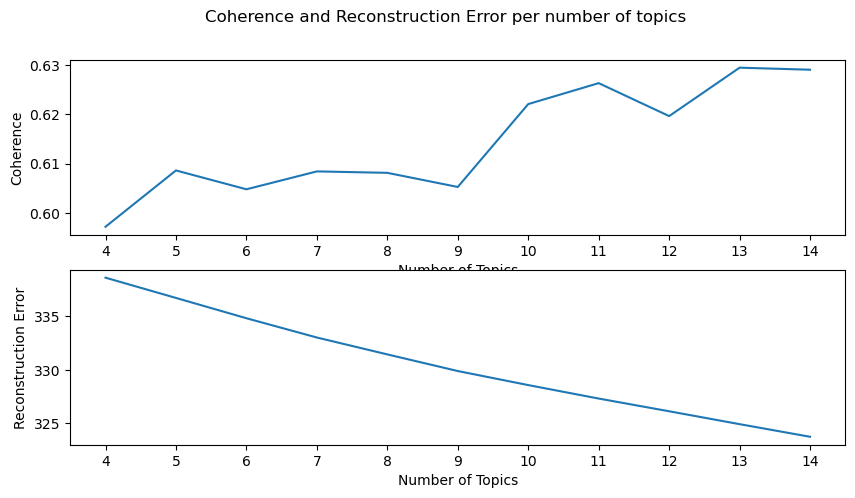

In [414]:
plotting_topic_numbers(df_grouped_by_scene, 'line_text_pp', list_topic_nos=[4, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14], model='nmf')

For NMF, based on the coherence score, 11 or 13 topics seems to work well. I am afraid 13 topics is overfitting, so I will try 11 first. Coherence scores are great!

### 4.2 LDA: Finding optimal no of topics  <a class="anchor" id="section_4_2"></a>

Starting  4
Finished  4
Starting  5
Finished  5
Starting  6
Finished  6
Starting  7
Finished  7
Starting  8
Finished  8
Starting  9
Finished  9
Starting  10
Finished  10
Starting  11
Finished  11
Starting  12
Finished  12
Starting  13
Finished  13
Starting  14
Finished  14


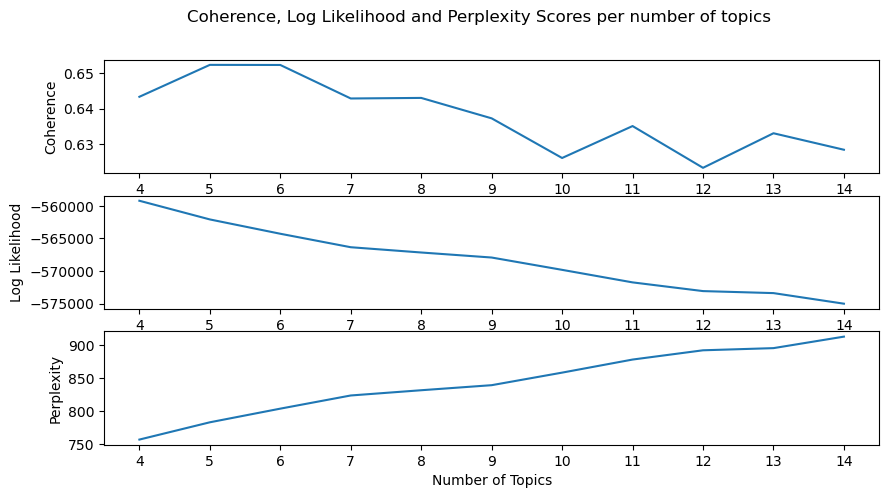

In [397]:
plotting_topic_numbers(df_grouped_by_scene, 'line_text_pp', list_topic_nos=[4, 5, 6, 7, 8 , 9, 10, 11, 12, 13, 14], model='lda')

For LDA, a choice of 5 or 6 topic seems to be ideal. This is very different compared to NMF, but let's try this for now. Coherence scores are great!

In [ ]:
# source: https://www.kaggle.com/code/sathvisiva/topic-modelling-and-sentiment-analysis

In [270]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx , topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words -1:-1]]))


In [363]:
no_features = 1000
count_vectorizer = CountVectorizer(max_df = 0.95, min_df = 2, max_features=no_features, stop_words='english')
fitted_count_vectorizer = count_vectorizer.fit_transform(df_grouped_by_scene.line_text_pp)
vectorized_feature_names = count_vectorizer.get_feature_names()


/Users/elinewesterbeek/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [416]:
no_topic_nmf = 8
no_topic_lda = 6

no_top_words = 20


### 4.3 Displaying NMF topics  <a class="anchor" id="section_4_3"></a>

While coherence scores said I would need more topics, I found them to become too specific... need to discuss with Luuk and Shantanu to see their opinion

In [417]:
nmf = NMF(n_components=no_topic_nmf, random_state = 1, alpha =.1, l1_ratio=.5, init = 'nndsvd').fit(fitted_count_vectorizer)


In [418]:
display_topics(nmf ,vectorized_feature_names, no_top_words)

Topic 0:
great thanks sound laugh tonight place night everybody question friend movie coming listen happy guess stuff talking wanted today salesman
Topic 1:
phone hello client answer calling listen imitating sound transfer voice ringing month howard second later whisper meeting idiot saying message
Topic 2:
thing talking everybody saying listen wanted business start believe night guess money called getting meeting totally trying stuff place better
Topic 3:
office raise everybody manager today place camera deangelo talking start conference hello think second leave looking holly friend people meeting
Topic 4:
sorry laugh friend second hello manager voice night better trying thanks wanted funny pretty getting minute stupid guess probably laughing
Topic 5:
paper dunder mifflin company business scranton manager hello client start today question talking branch salesman people better second dollar money
Topic 6:
party christmas start everybody holly committee throw planning break coming birth

- Topic 0: seems to be about friendship and laughter
- Topic 1: seems to be about calling clients, messages etc. (phone)
- Topic 2:
- Topic 3: Seems to be about the office, business conferences, meetings, etc. (work activities)
- Topic 4: Seems to be about jokes
- Topic 5: seems to be about the company (dunder mifflin, the paper company from scranton)
- Topic 6: seems to be about the parties they throw (often crhistmas or birthday parties thrown by the party committee, where pizza is served)
- Topic 7: Seems to be about jokes again

### 4.4 Displaying LDA topics  <a class="anchor" id="section_4_4"></a>

In [433]:
lda = LatentDirichletAllocation(n_components=no_topic_lda, max_iter = 5, learning_method = 'online', learning_offset=50., random_state=0).fit(fitted_count_vectorizer)


In [434]:
display_topics(lda , vectorized_feature_names , no_top_words)


Topic 0:
phone sorry office hello thing point woman probably second saying friend called listen meeting pretty guess totally minute conference weird
Topic 1:
great dunder mifflin robert client singing number thing wrong playing family manager start beautiful wedding building smile world lunch child
Topic 2:
thing getting paper great company better office person today tonight leave stupid ready somebody computer sorry people watch talking heart
Topic 3:
laugh party happy thanks christmas holly coming manager funny question coffee birthday wanted excited today sound drink second video chance
Topic 4:
thing night money business think great friend picture office place house sound dollar school everybody exactly question couple raise girlfriend
Topic 5:
throw trying welcome scranton morning movie sorry nellie heard chair great idiot remember senator dinner matter machine decided early leaving


- Topic 0: phones, meetings, conferences
- Topic 1: the company, clients and roles
- Topic 2:  similar to 1
- Topic 3: parties and holidays
- Topic 4: making money? and business
- Topic 5: ??


## 5. TO EXPLORE MORE IN NEXT UPDATE: Zero-shot hugging face classification: pre-defined categories <a class="anchor" id="chapter5"></a>

In [283]:
# https://huggingface.co/tasks/zero-shot-classification

pipe = pipeline("zero-shot-classification", model="valhalla/distilbart-mnli-12-3")

In [299]:
hugging_face_sample = df_grouped.sample(50)

predicted_topics = []
for line in hugging_face_sample.line_text:
    result = pipe(line,
                   candidate_labels=["love", "friendship", "fun, party and food", "business and management"])
    predicted_topic = result['labels'][0]
    predicted_topics.append(predicted_topic)

hugging_face_sample['hugging_face_predicted_topic'] = predicted_topics

In [300]:
hugging_face_sample.hugging_face_predicted_topic.value_counts()

business and management    30
fun, party and food        14
love                        4
friendship                  2
Name: hugging_face_predicted_topic, dtype: int64

In [301]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
hugging_face_sample

,season,episode,scene,line_text,hugging_face_predicted_topic
3362,7,4,26,"talking paper. relationships, ability point making bigger there.",business and management
1976,4,13,29,"[walks tossing basketballs, grabs ] . [kicks gymnasium ceiling]","fun, party and food"
1405,3,20,72,"looking today. training session. , customer relations. never. ' grump.",business and management
1978,4,13,32,"family. martinez. accountant extraordinaire. justin. philbin. already beesly, office hottie. [laughs] already dated office, number three, ? think? ? bring better. justin, willing commit honor, spending summer dunder mifflin? think, special.",business and management
512,2,12,40,"always stash bubble house. , hectic, tiring , click soothing. interviewer]",business and management
3788,7,23,9,"social . french revolution, black panthers, communism. . talking, . social . everybody calls rebellion. enters brandishes , returns gesture] today. unfortunately, operation overthrow everything, noted tears , hangs signs place]",business and management
4614,9,8,1,"yesterday, figured affair husband. comes awkward cruel great, business usual.",business and management
4629,9,8,29,"sorry, stupid, stupid , follow something, masculinity issues-- !",business and management
4807,9,15,19,"valentine' surprise hello? super romantic. something. [removes wooden instruments couple pieces bamboo. , musical instruments. island music together. cause [removes �� begins playing singing] cloppers. called bembe. [sings echoes] obviously, , early surprise happy valentine' sweetheart. [tries embrace begins playing cloppers] saying, excited wallace meeting. please. clark. wallace knows three months. stalls] wallace three months? . knows ' touch whole . , -speed internet turks caicos, people. every bembe .",love
1339,3,19,17,"... ... visual . facts. science museum handed pamphlet electricity. science museum metal , sticks straight... science.","fun, party and food"


In [302]:
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud, STOPWORDS

tokenizer = RegexpTokenizer(r'\w+')

def word_cloud_per_category(category):
    lines_by_category = hugging_face_sample.loc[hugging_face_sample['hugging_face_predicted_topic'] == category, 'line_text']
    words_by_category = []
    for line in lines_by_category:
        words = tokenizer.tokenize(line)
        words_by_category.extend(words)
    word_cloud_dict = Counter(words_by_category)
    wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(word_cloud_dict)
    plt.figure(figsize=(15,8))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#michael_words = [word.lower() for word in michael_words]
#michael_words = list(filter(lambda x: x not in most_common, michael_words))
#michael_words = list(filter(lambda x: x not in stopwords, michael_words))
#michael_words = list(filter(lambda x: len(x) > 2, michael_words))

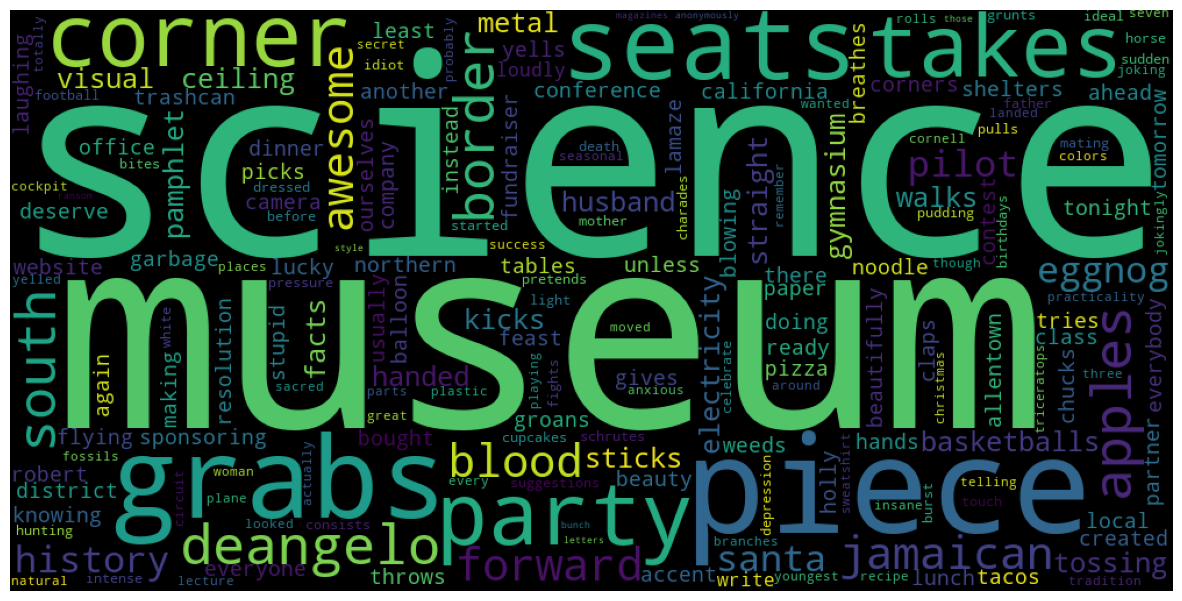

In [303]:
word_cloud_per_category("fun, party and food")

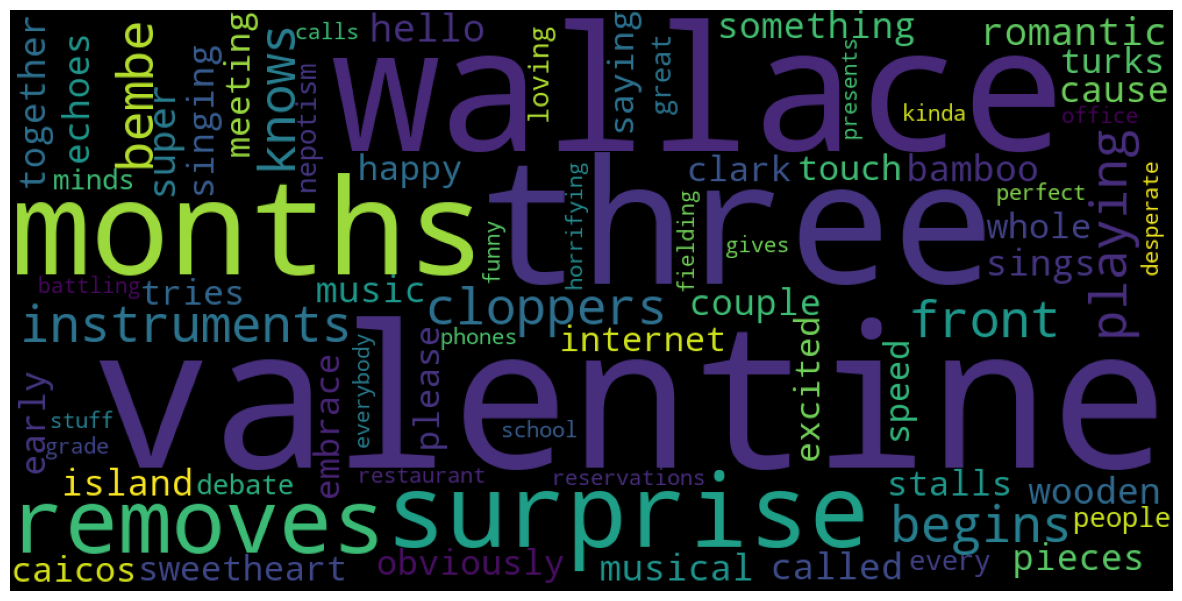

In [304]:
word_cloud_per_category("love")

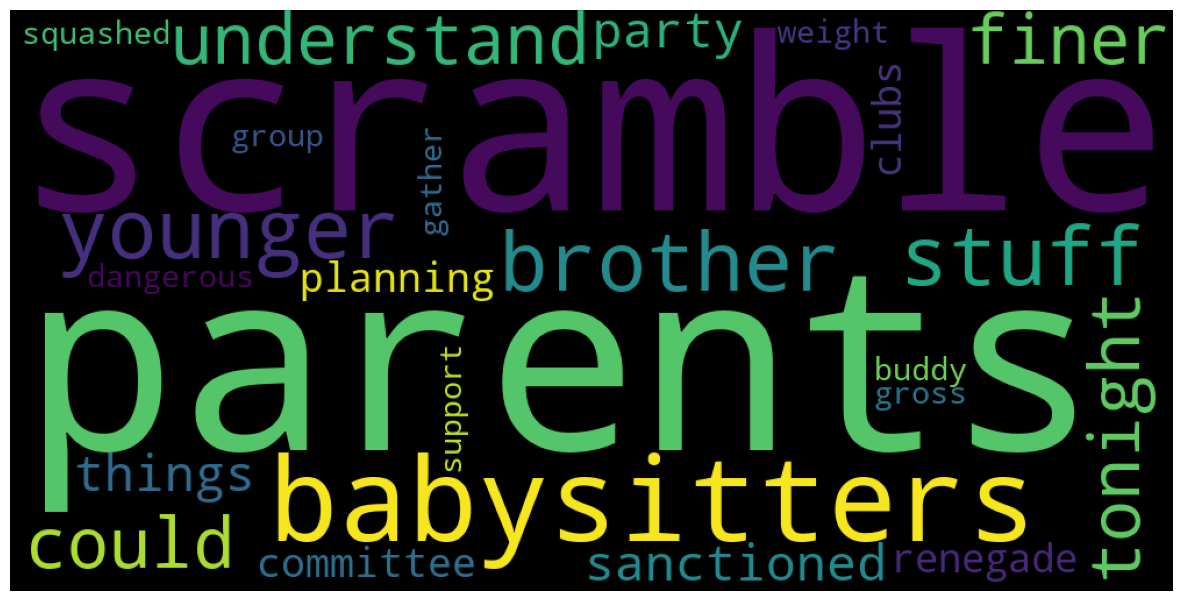

In [305]:
word_cloud_per_category("friendship")

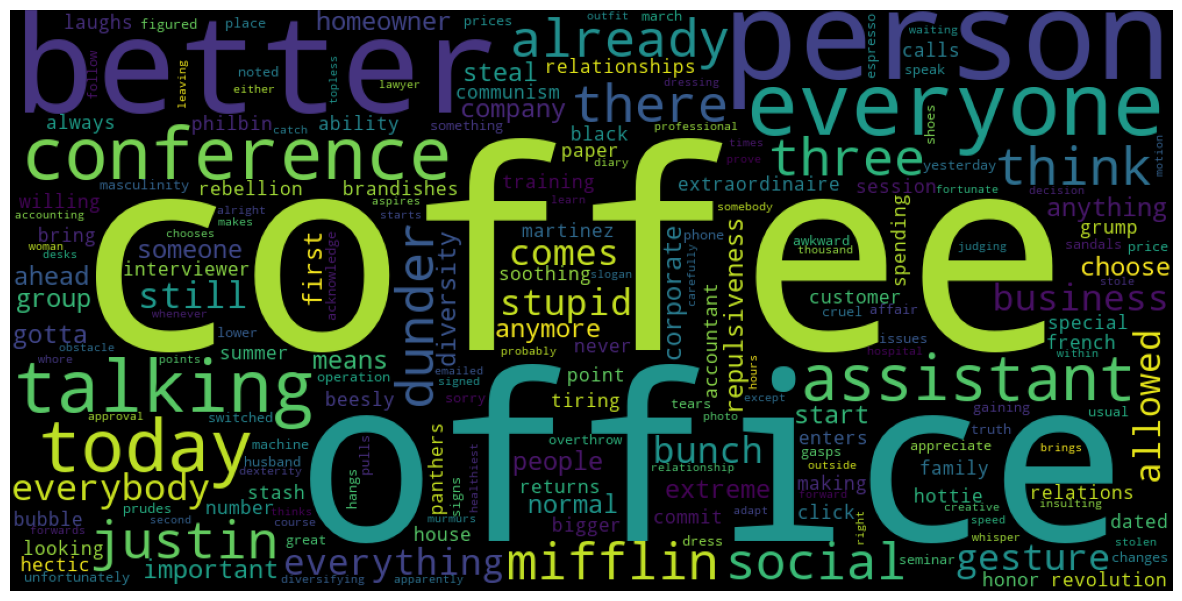

In [306]:
word_cloud_per_category("business and management")